In [5]:
import cv2
import os
from PIL import Image
from flow_estimation import FlowEstimator
import numpy as np

In [6]:
flow_estimator = FlowEstimator("gmflow/pretrained/gmflow_things-e9887eda.pth", "cuda")

In [8]:
img1 = Image.open("frames2/0002.png")
img2 = Image.open("frames2/0005.png")

In [9]:
flow = flow_estimator.estimate_flow(np.array(img1), np.array(img2), return_as_tensor=False)

/home/pablo/miniconda3/envs/scgs/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
def warp_with_flow(flow, curImg):
    flow = -flow
    h, w = flow.shape[:2]
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    nextImg = cv2.remap(curImg, flow, None, cv2.INTER_LINEAR)

    mask = np.ones_like(curImg)
    mask = cv2.remap(mask, flow, None, cv2.INTER_LINEAR)
    mask[mask > 0] = 255
    mask[mask <= 0] = 0
    mask = mask.astype(np.uint8)

    return nextImg, mask

In [11]:
warped2, mask = warp_with_flow(flow, np.array(img1))

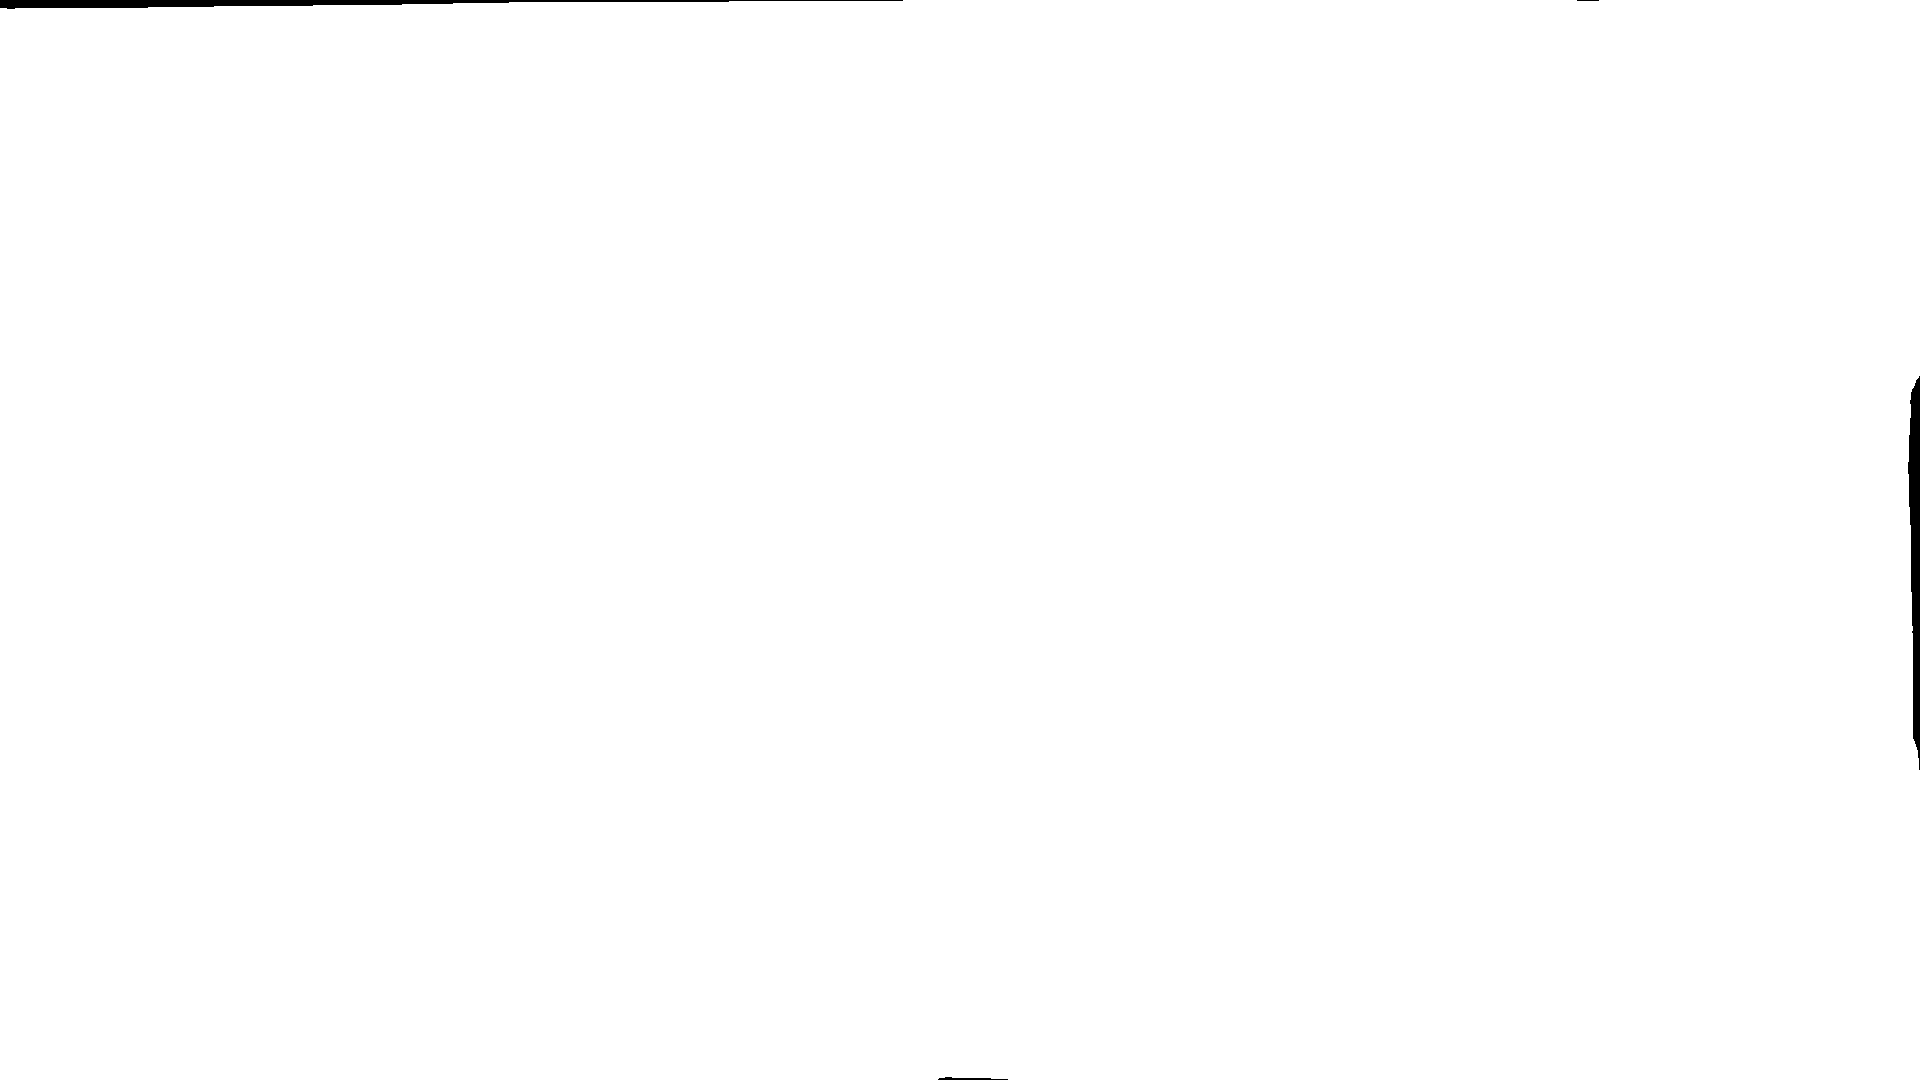

In [13]:
Image.fromarray(mask)

Condition: It moved (optical flow>thres) and it stayed similar

In [48]:
flow.shape[1]

1920

In [30]:
flow_hor = np.abs(flow[:,:,0])
flow_ver = np.abs(flow[:,:,1])

mask1 = np.zeros_like(flow_hor)
mask2 = np.zeros_like(flow_ver)

threshold = 20

mask1[flow_hor > threshold] = 1
mask2[flow_ver > threshold] = 1

mask2 = (mask2 * 255).astype(np.uint8)
mask1 = (mask1 * 255).astype(np.uint8)

final_mask = cv2.bitwise_or(mask1, mask2)

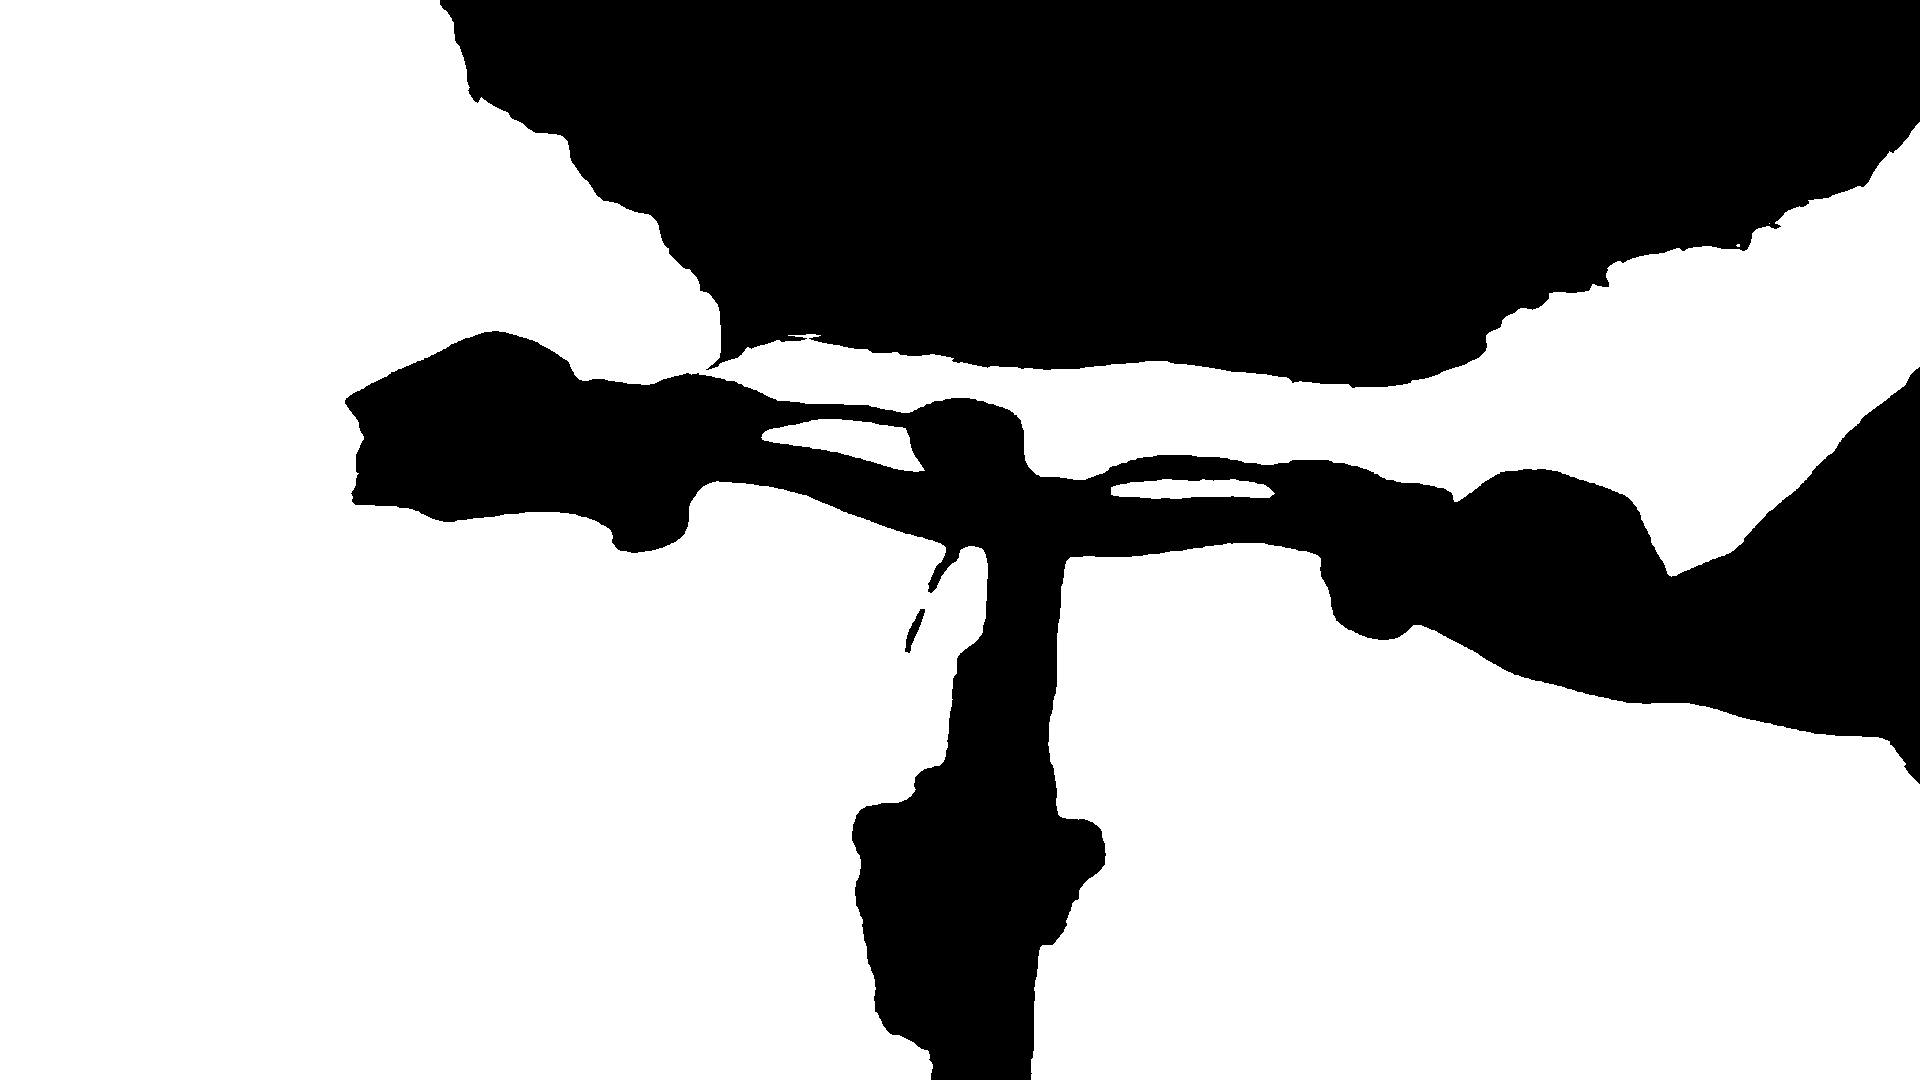

In [32]:
Image.fromarray(final_mask)

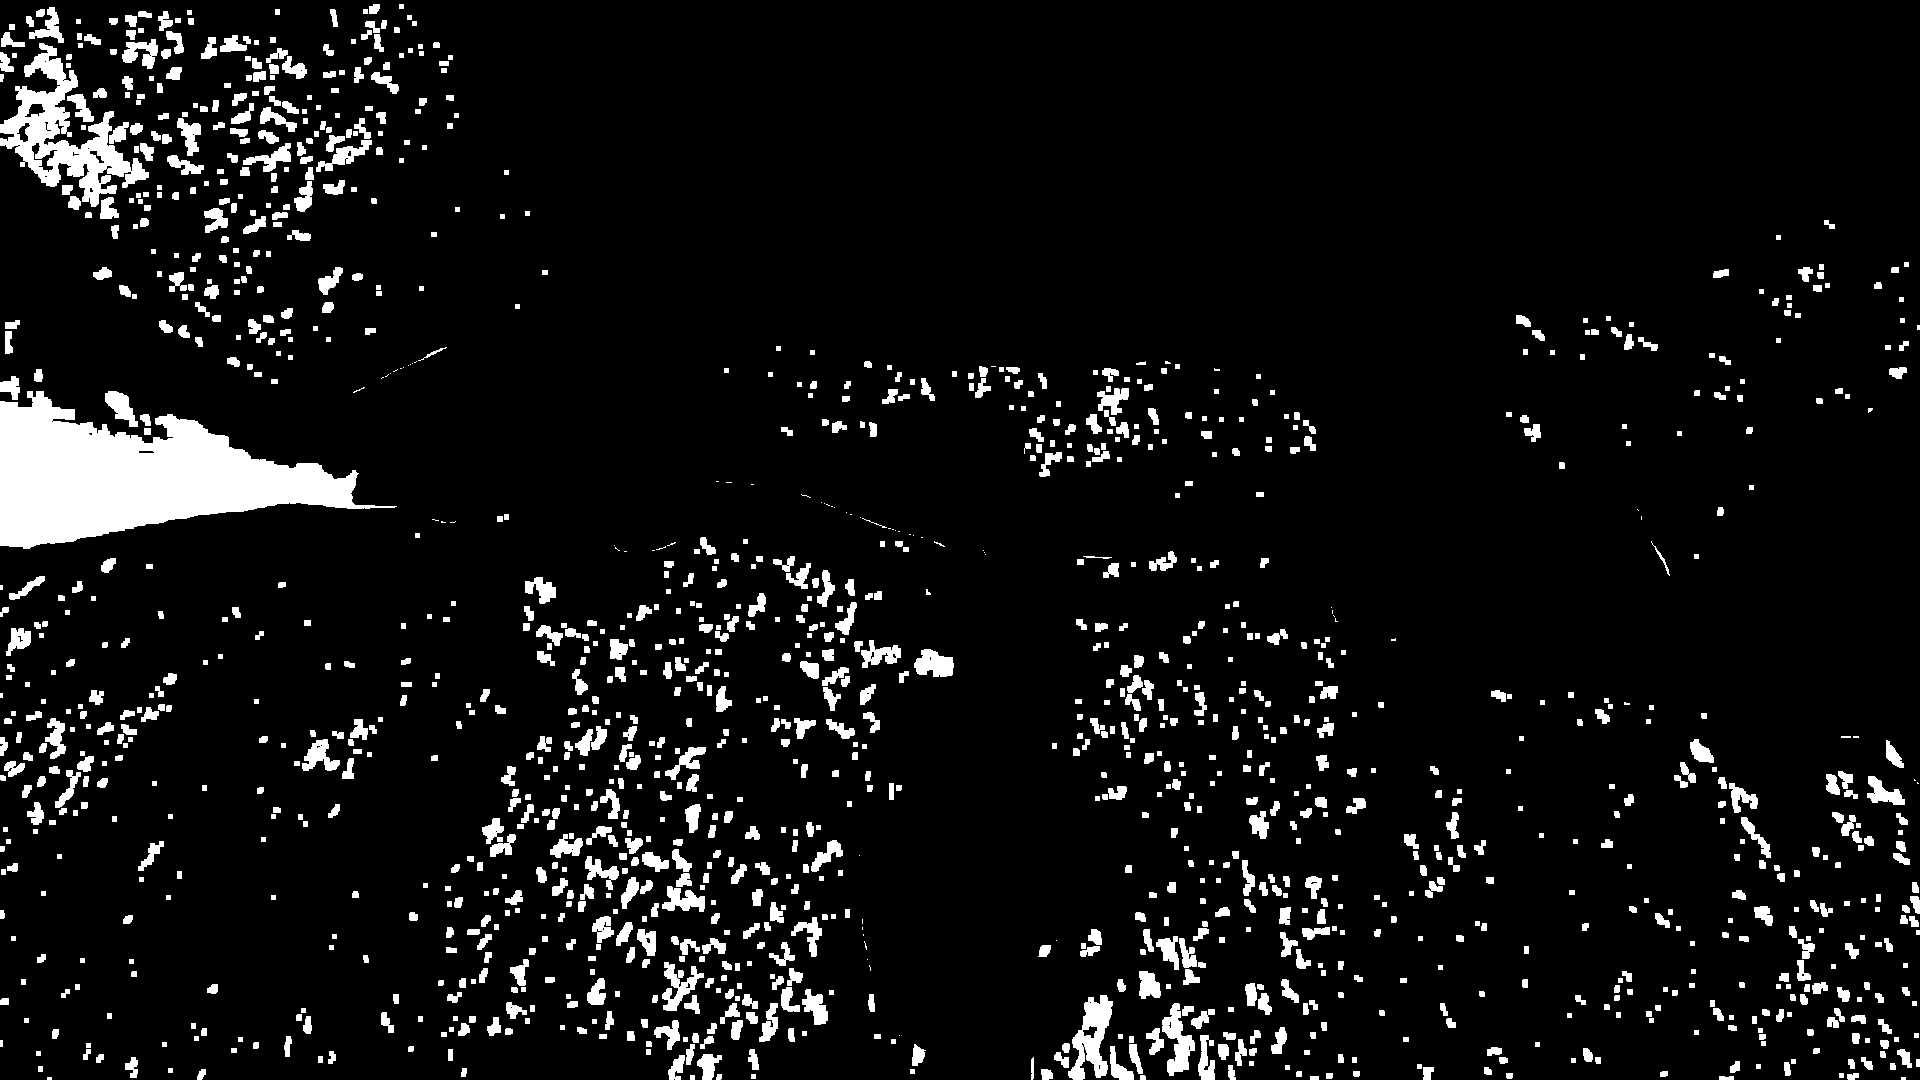

In [54]:
ghosting = cv2.bitwise_and(final_mask, diff)
Image.fromarray(ghosting)

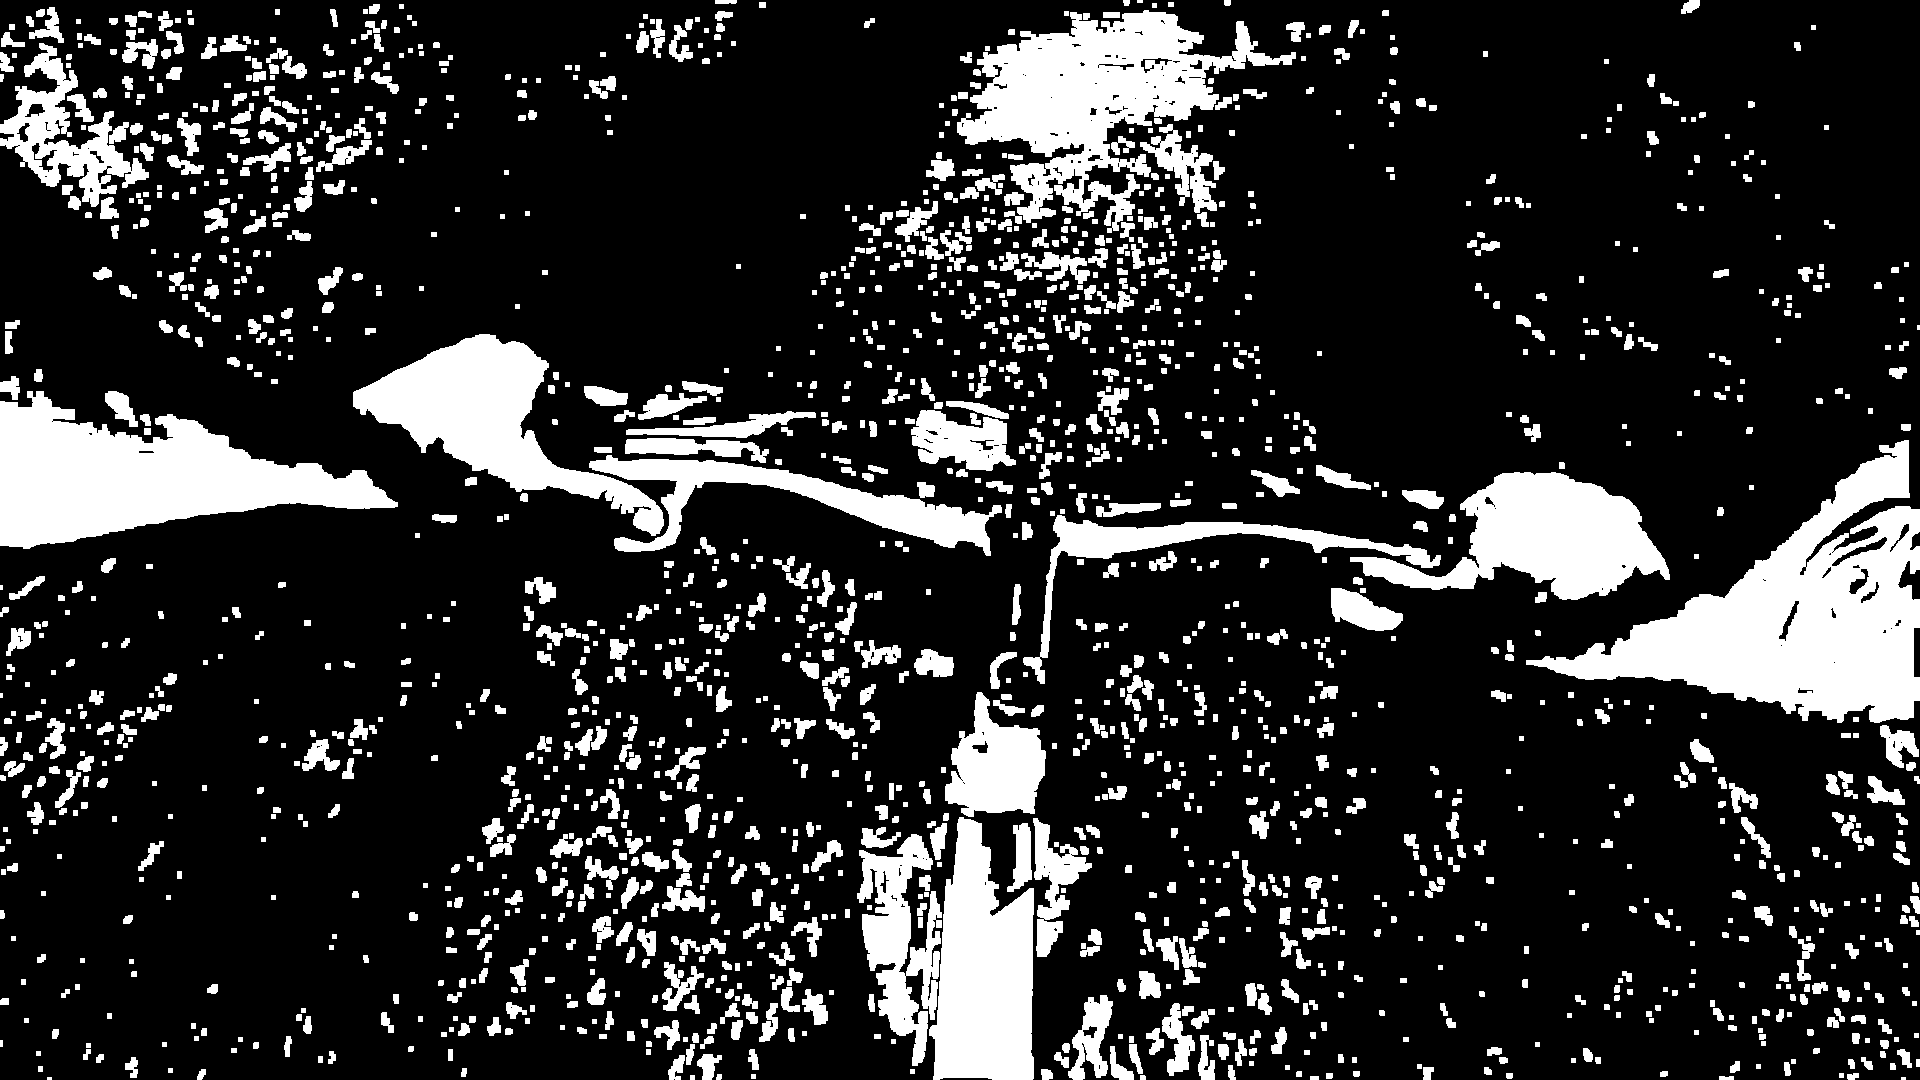

In [53]:
w_gs = cv2.cvtColor(warped2, cv2.COLOR_RGB2GRAY)
w_gs = cv2.equalizeHist(w_gs)
im_gs = cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2GRAY)
im_gs = cv2.equalizeHist(im_gs)
diff = cv2.absdiff(w_gs, im_gs)
_, diff = cv2.threshold(diff, 10, 255, cv2.THRESH_BINARY_INV)

# remove noise
kernel = np.ones((3,3),np.uint8)
diff = cv2.erode(diff, kernel, iterations=1)
diff = cv2.dilate(diff, kernel, iterations=2)

Image.fromarray(diff)

In [25]:
# inpaint warped2 with diff mask
warped2 = cv2.inpaint(warped2, diff, 3, cv2.INPAINT_TELEA)

KeyboardInterrupt: 

In [10]:
#Image.fromarray(warped2)
#img1
#Image.fromarray(cv2.addWeighted(np.array(img2), 0.5, warped2, 0.5, 0))
#Image.fromarray(cv2.addWeighted(np.array(img2), 0.5, np.array(img2), 0.5, 0))
img1.save("1.png")
Image.fromarray(warped2).save("2.png")
img2.save("3.png")

In [8]:
flow_graph = flow
flow_graph = np.concatenate([flow_graph, np.zeros_like(flow_graph[..., 0:1])], axis=-1)
flow_graph = (flow_graph - np.min(flow_graph)) / (np.max(flow_graph) - np.min(flow_graph))
flow_graph_np = (flow_graph * 255).astype(np.uint8)

In [13]:
flow_im = flow[:, :, 0]# + flow[:, :, 1]
flow_im = (flow_im - np.min(flow_im)) / (np.max(flow_im) - np.min(flow_im))
flow_im = (flow_im * 255).astype(np.uint8)
flow_im = cv2.applyColorMap(flow_im, cv2.COLORMAP_JET)

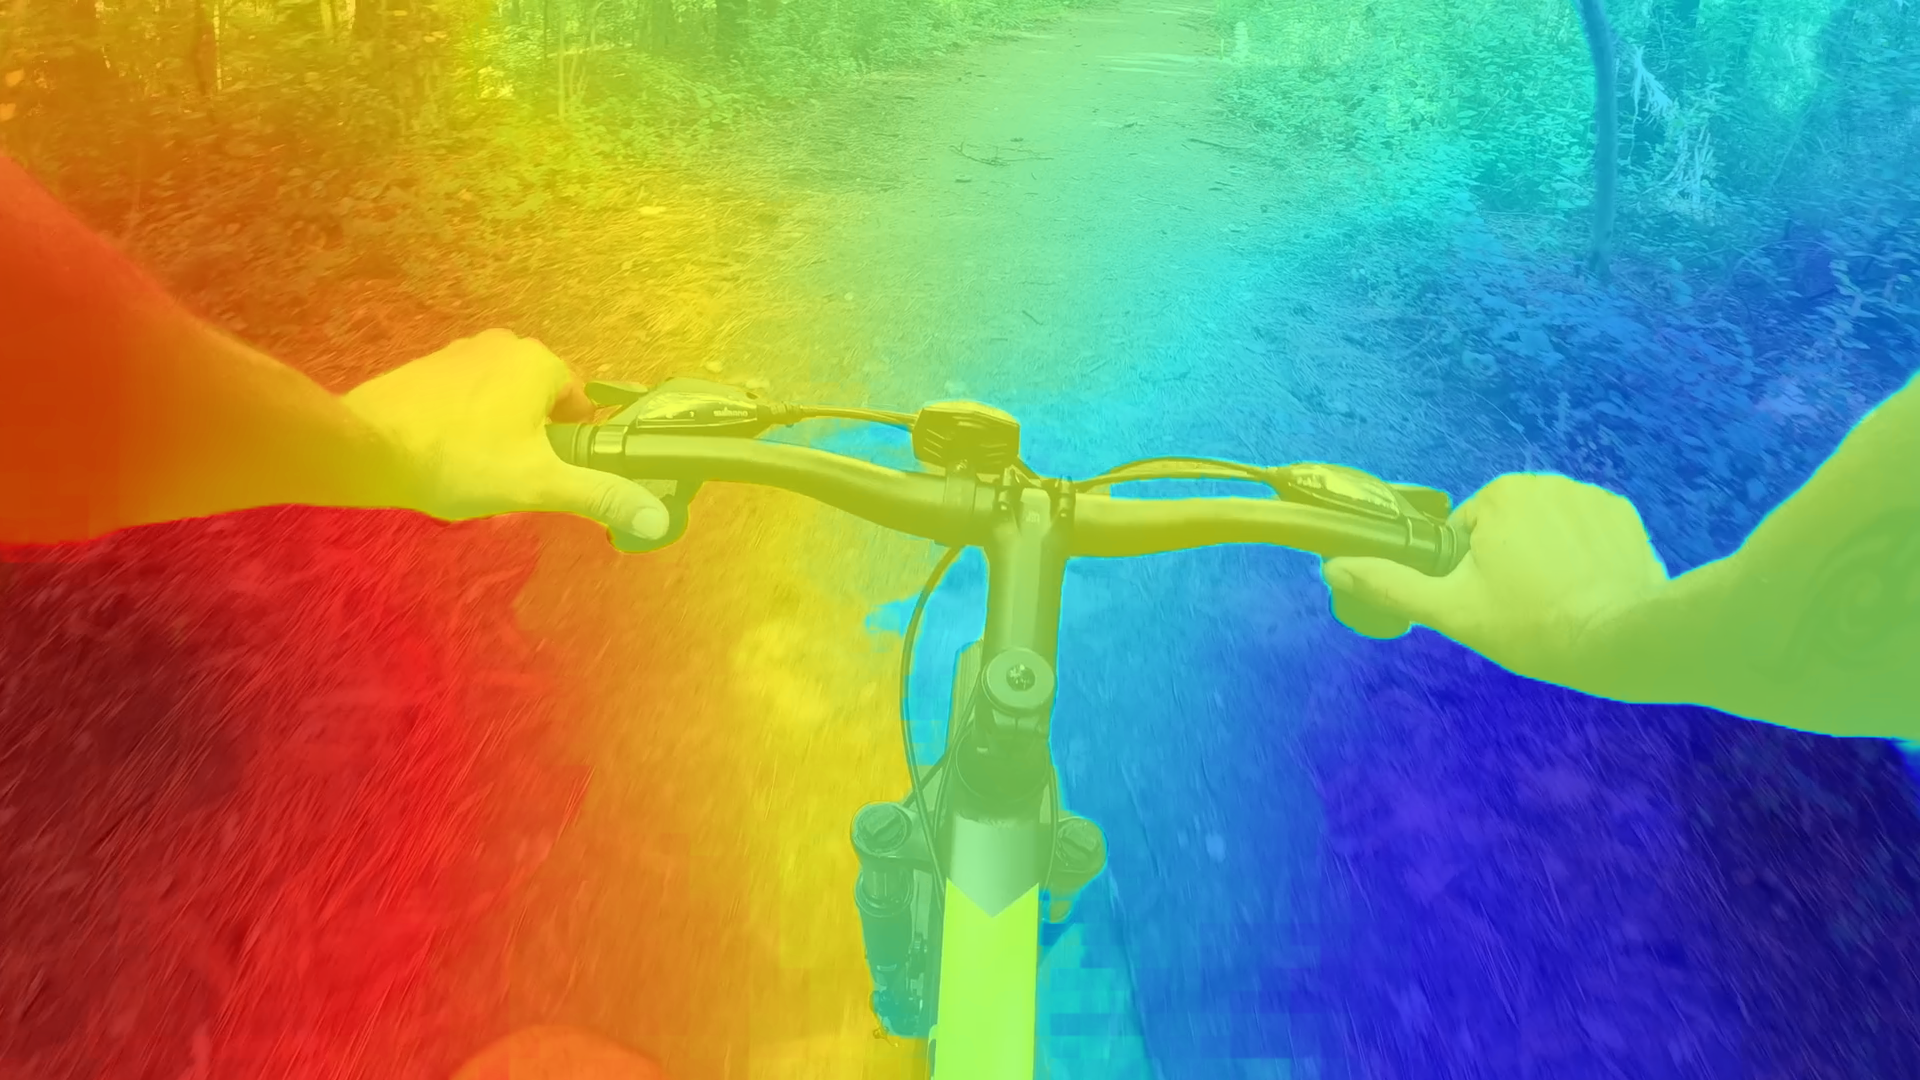

In [15]:
overlay = cv2.addWeighted(np.array(img1), 0.3, flow_im, 0.7, 0)
Image.fromarray(overlay)